In [1]:
import urllib.request
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import requests
import io
import seaborn as sns
import matplotlib.ticker as ticker

# Pobranie granic dla powiatów

In [2]:
url = 'https://www.gis-support.pl/downloads/2022/powiaty.zip'
local_zip_path = 'powiaty.zip'

urllib.request.urlretrieve(url, local_zip_path)

with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
    zip_ref.extractall('jednostki_administracyjne')

extracted_files = os.listdir('jednostki_administracyjne')
extracted_files

['powiaty.dbf',
 'powiaty.cpg',
 'powiaty.shx',
 'powiaty.qmd',
 'powiaty.prj',
 'powiaty.shp']

In [3]:
shapefile_path = 'jednostki_administracyjne/powiaty.shp'
mapa_powiaty = gpd.read_file(shapefile_path)
mapa_powiaty.dtypes


gml_id          object
JPT_SJR_KO      object
JPT_POWIER      object
JPT_KOD_JE      object
JPT_NAZWA_      object
JPT_ORGAN_      object
JPT_JOR_ID      object
WERSJA_OD       object
WERSJA_DO       object
WAZNY_OD        object
WAZNY_DO        object
JPT_KOD__1      object
JPT_NAZWA1      object
JPT_ORGAN1      object
JPT_WAZNA_      object
ID_BUFORA_      object
ID_BUFORA1      object
ID_TECHNIC      object
IIP_PRZEST      object
IIP_IDENTY      object
IIP_WERSJA      object
JPT_KJ_IIP      object
JPT_KJ_I_1      object
JPT_KJ_I_2      object
JPT_OPIS        object
JPT_SPS_KO      object
ID_BUFOR_1      object
JPT_ID          object
JPT_POWI_1      object
JPT_KJ_I_3      object
JPT_GEOMET      object
JPT_GEOM_1      object
SHAPE_LENG      object
SHAPE_AREA      object
REGON           object
RODZAJ          object
geometry      geometry
dtype: object

# Funkcje do tworzenia wykresów

In [4]:
def make_map_subplot(ax, data, title, auto_scale=True):
    mapa_powiaty['JPT_NAZWA_'] = mapa_powiaty['JPT_NAZWA_'].str.strip().str.upper()
    data['powiatName'] = data['powiatName'].str.upper()

    merged_data = mapa_powiaty.merge(data, left_on='JPT_NAZWA_', right_on='powiatName')
    mapa_powiaty.plot(ax=ax, color='lightgrey', edgecolor='black')

    if auto_scale:
        vmin = data['value'].min()
        vmax = data['value'].max()
    else:
        vmin = data['value'].quantile(0.02)
        vmax = data['value'].quantile(0.98)

    merged_data.plot(column='value', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, vmin=vmin, vmax=vmax)
    ax.set_title(title, fontsize=16)
    ax.axis('off')

In [5]:
def plot_district_data(df, powiat_name, category_name, plot_title, year):
    district_change = df[(df['powiatName'] == powiat_name) &
                         (df['categoryName'] == 'zmiana liczby ludności na 1000 mieszkańców') &
                         (df['year'] >= year)]

    district_apartments = df[(df['powiatName'] == powiat_name) &
                             (df['categoryName'] == category_name) &
                             (df['year'] >= year)]

    plt.figure(figsize=(16, 6))

    ax1 = plt.subplot(1, 1, 1)
    ax1.fill_between(district_change['year'], district_change['value'], color='b', alpha=0.3, label='Zmiana liczby ludności na 1000 mieszkańców')
    ax1.set_title(plot_title)
    ax1.set_xlabel('Rok')
    ax1.set_ylabel('Zmiana liczby ludności na 1000 mieszkańców', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.grid(True)
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))

    ax2 = ax1.twinx()
    ax2.plot(district_apartments['year'], district_apartments['value'], color='r', linestyle='-', marker='o', label=category_name)
    ax2.set_ylabel(category_name, color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='best')

    plt.xticks(district_change['year'], rotation=45)
    plt.tight_layout()
    plt.show()

# Pobranie i przygotowanie danych

In [6]:
url = 'https://github.com/PawelJasinski25/Wizualizacja/raw/main/powiaty.zip'

response = requests.get(url)
if response.status_code == 200:
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        print(z.namelist())
        with z.open('powiaty.csv') as f:
            df = pd.read_csv(f)
            print(df.head())
else:
    print(f'Failed to download file: {response.status_code}')


['powiaty.csv']
  id  categoryId          categoryName      powiatId        powiatName  \
0  0      1230.0  Biblioteki publiczne  1.121200e+10  Powiat bocheński   
1  1      1230.0  Biblioteki publiczne  1.121200e+10  Powiat bocheński   
2  2      1230.0  Biblioteki publiczne  1.121200e+10  Powiat bocheński   
3  3      1230.0  Biblioteki publiczne  1.121200e+10  Powiat bocheński   
4  4      1230.0  Biblioteki publiczne  1.121200e+10  Powiat bocheński   

     year  value  
0  1995.0   37.0  
1  1996.0   37.0  
2  1997.0   37.0  
3  1998.0   37.0  
4  1999.0   37.0  


In [7]:
df.head()

,id,categoryId,categoryName,powiatId,powiatName,year,value
0,0,1230.0,Biblioteki publiczne,1.121200e+10,Powiat bocheński,1995.0,37.0
1,1,1230.0,Biblioteki publiczne,1.121200e+10,Powiat bocheński,1996.0,37.0
2,2,1230.0,Biblioteki publiczne,1.121200e+10,Powiat bocheński,1997.0,37.0
3,3,1230.0,Biblioteki publiczne,1.121200e+10,Powiat bocheński,1998.0,37.0
4,4,1230.0,Biblioteki publiczne,1.121200e+10,Powiat bocheński,1999.0,37.0


In [8]:
change = df[(df['categoryName'] == 'zmiana liczby ludności na 1000 mieszkańców')]
change = change[change['value'].notnull()]
average_change = change.groupby(['powiatId', 'powiatName'])['value'].mean().reset_index()
average_change_sorted = average_change.sort_values(by='value', ascending=False)

In [9]:
population = df[(df['categoryName'] == 'ludność w tysiącach') & (df['year'] == 2022)]
population = population[population['value'].notnull()]

In [10]:
apartaments = df[(df['categoryName'] == 'Mieszkania oddane do użytkowania') & (df['year'] == 2022)]
apartaments = apartaments[apartaments['value'].notnull()]

In [11]:
bike = df[(df['categoryName'] == 'Długość dróg dla rowerów') & (df['year'] == 2022)]
bike = bike[bike['value'].notnull()]

In [12]:
bus = df[(df['categoryName'] == 'Czynne przystanki komunikacji miejskiej') & (df['year'] == 2022)]
bus = bus[bus['value'].notnull()]

In [13]:
libraries = df[(df['categoryName'] == 'Czynne przystanki komunikacji miejskiej') & (df['year'] == 2022)]
libraries = libraries[libraries['value'].notnull()]

# Porównanie średniej zmiany liczby ludności z róznymi kategoriami

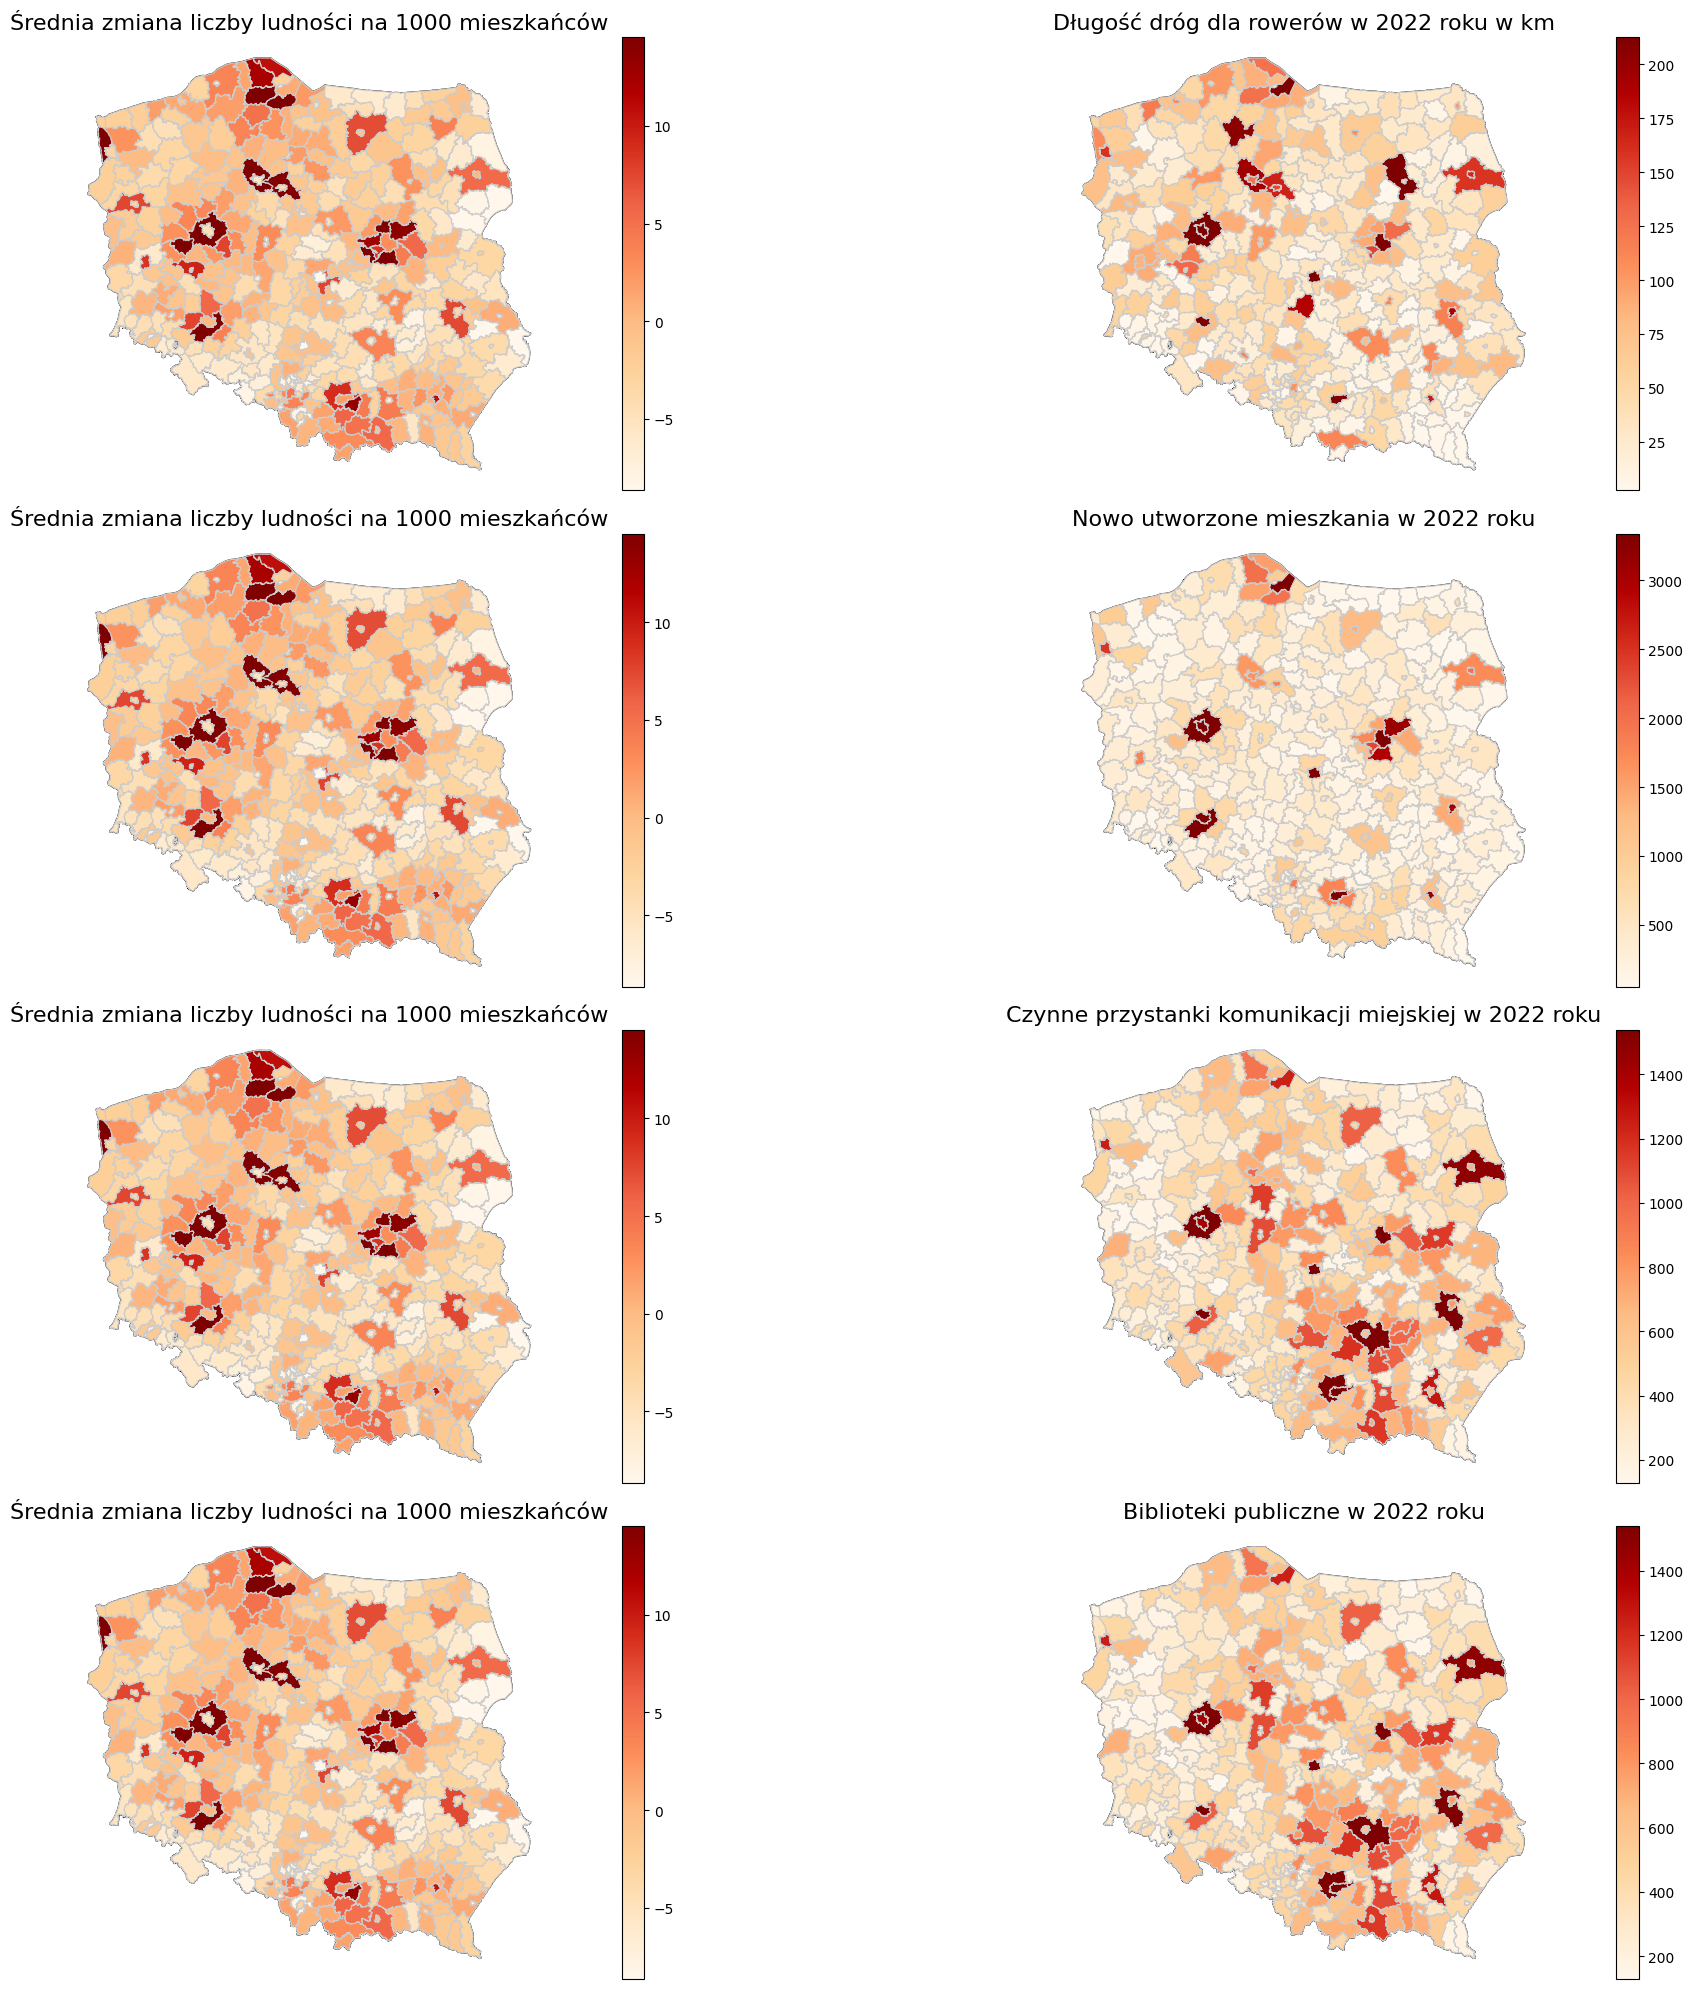

In [ ]:
fig, axs = plt.subplots(4, 2, figsize=(24, 20))

make_map_subplot(axs[0, 0], average_change_sorted, "Średnia zmiana liczby ludności na 1000 mieszkańców",auto_scale=False)
make_map_subplot(axs[0, 1], bike, "Długość dróg dla rowerów w 2022 roku w km",auto_scale=False)
make_map_subplot(axs[1, 0], average_change_sorted, "Średnia zmiana liczby ludności na 1000 mieszkańców",auto_scale=False)
make_map_subplot(axs[1, 1], apartaments, "Nowo utworzone mieszkania w 2022 roku",auto_scale=False)
make_map_subplot(axs[2, 0], average_change_sorted, "Średnia zmiana liczby ludności na 1000 mieszkańców",auto_scale=False)
make_map_subplot(axs[2,1], bus, "Czynne przystanki komunikacji miejskiej w 2022 roku",auto_scale=False)
make_map_subplot(axs[3, 0], average_change_sorted, "Średnia zmiana liczby ludności na 1000 mieszkańców",auto_scale=False)
make_map_subplot(axs[3,1], libraries, "Biblioteki publiczne w 2022 roku",auto_scale=False)

plt.tight_layout()
plt.show()


# Porównanie najlepszych i najgorszych powiatów

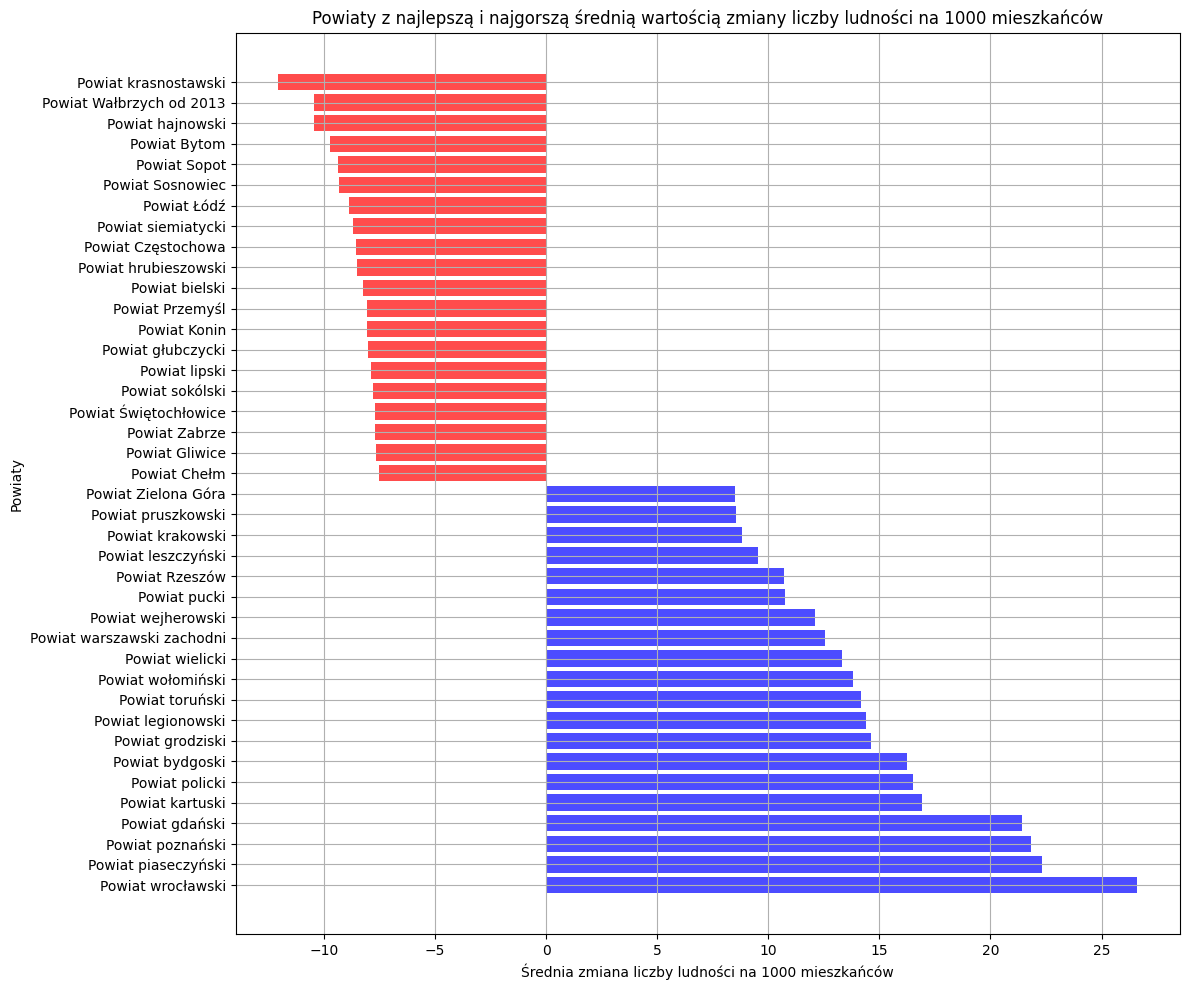

In [14]:
best_cities = average_change_sorted.head(20)
worst_cities = average_change_sorted.tail(20)
combined_data = pd.concat([best_cities, worst_cities])

fig, ax = plt.subplots(figsize=(12, 10))


colors = ['b'] * 20 + ['r'] * 20
ax.barh(combined_data['powiatName'], combined_data['value'], color=colors, alpha=0.7)
ax.set_title('Powiaty z najlepszą i najgorszą średnią wartością zmiany liczby ludności na 1000 mieszkańców')
ax.set_xlabel('Średnia zmiana liczby ludności na 1000 mieszkańców')
ax.set_ylabel('Powiaty')
ax.grid(True)

plt.tight_layout()
plt.show()


# Powiat wrocławski

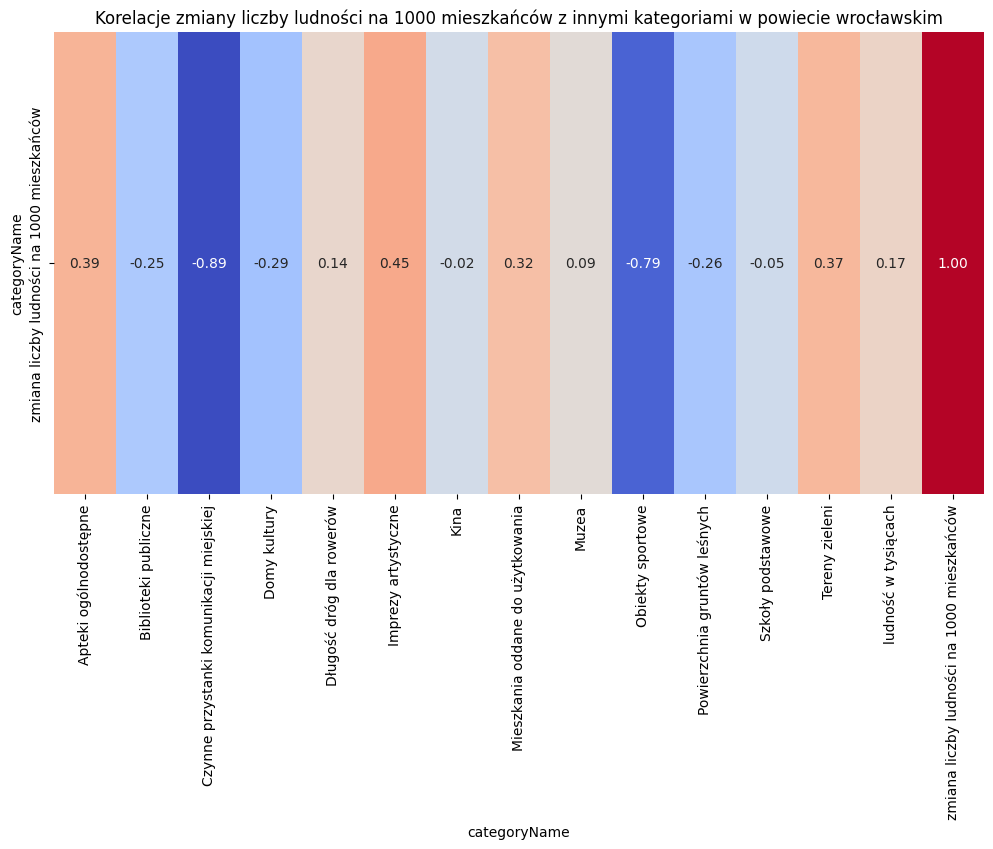

In [20]:
wroclawski_df = df[df['powiatName'] == 'Powiat wrocławski']
wroclawski_df = wroclawski_df[wroclawski_df['categoryName'].isin(['Instytucje muzyczne', 'Teatry']) == False]

wroclawski_df_pivot = wroclawski_df.pivot_table(index='year', columns='categoryName', values='value')
selected_categories = ['zmiana liczby ludności na 1000 mieszkańców']
corr_matrix = wroclawski_df_pivot.corr()

selected_corr_matrix = corr_matrix.loc[selected_categories]

plt.figure(figsize=(12, 6))
sns.heatmap(selected_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=False)
plt.title('Korelacje zmiany liczby ludności na 1000 mieszkańców z innymi kategoriami w powiecie wrocławskim')
plt.show()

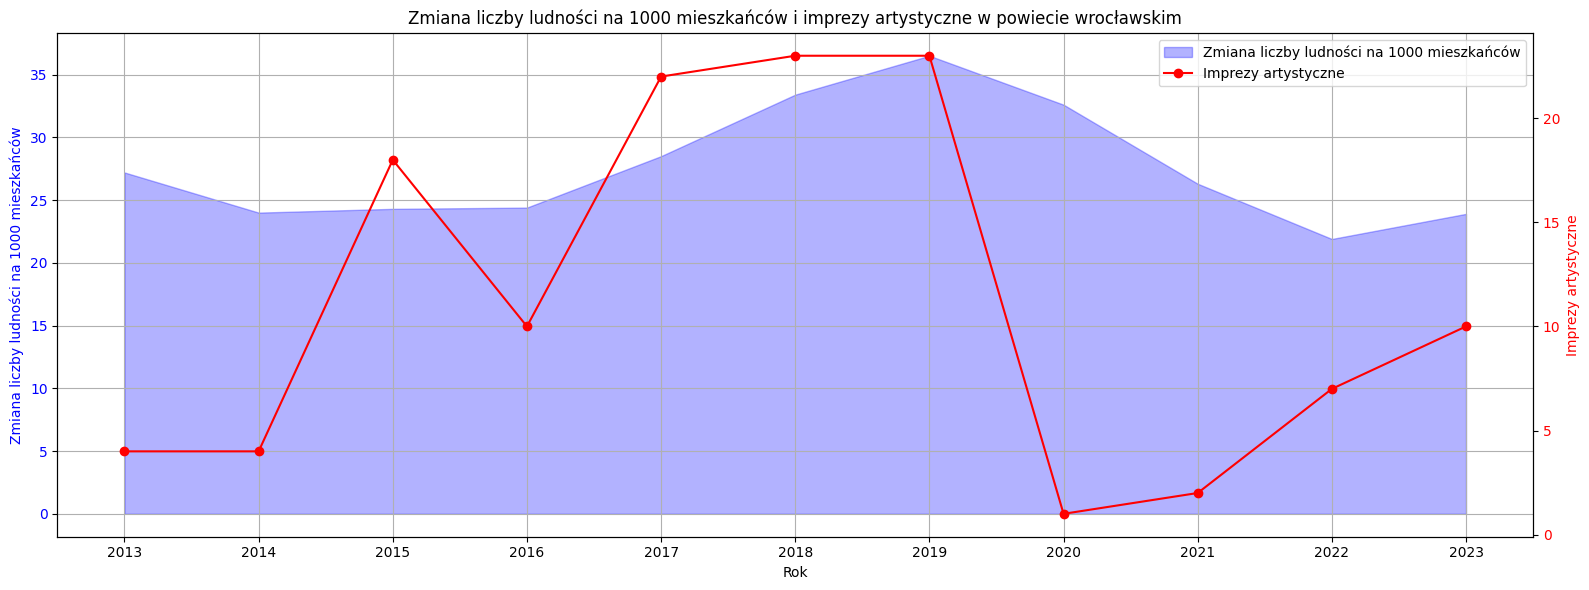

In [ ]:
plot_district_data(df, 'Powiat wrocławski', 'Imprezy artystyczne', 'Zmiana liczby ludności na 1000 mieszkańców i imprezy artystyczne w powiecie wrocławskim',2013)

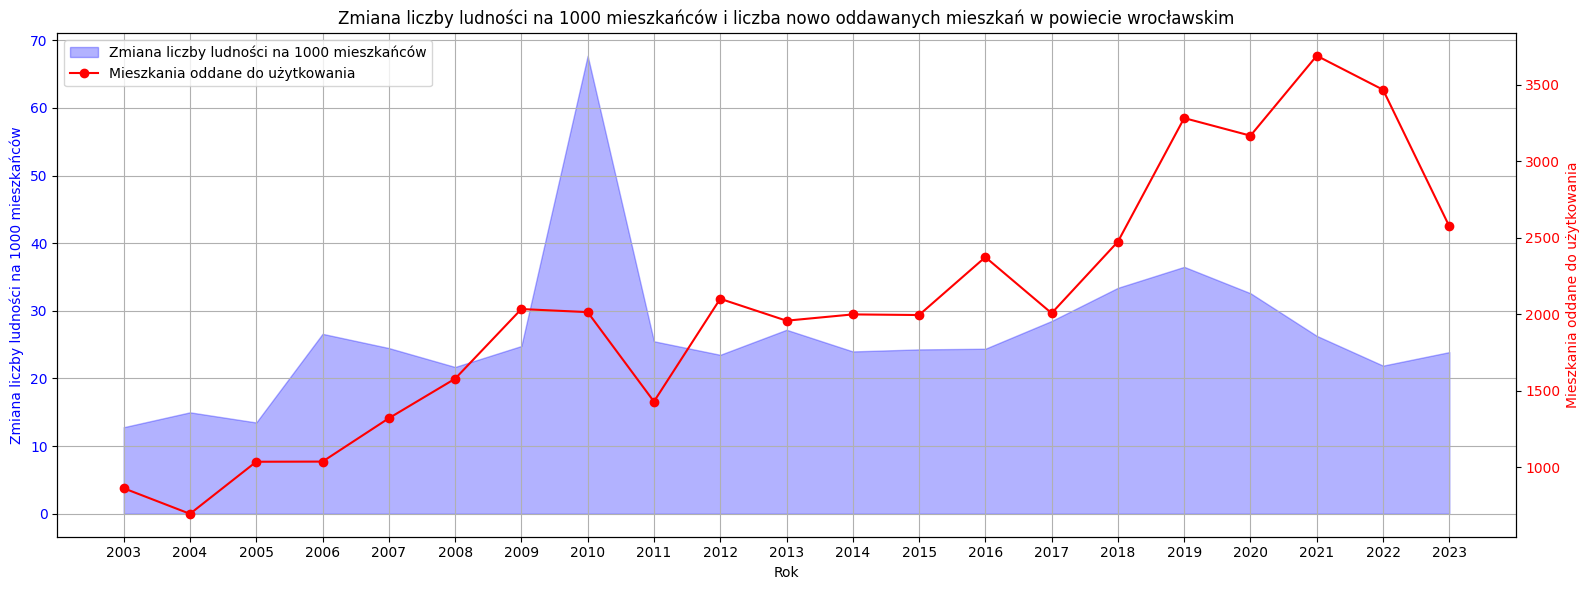

In [ ]:
plot_district_data(df, 'Powiat wrocławski', 'Mieszkania oddane do użytkowania', 'Zmiana liczby ludności na 1000 mieszkańców i liczba nowo oddawanych mieszkań w powiecie wrocławskim',2003)

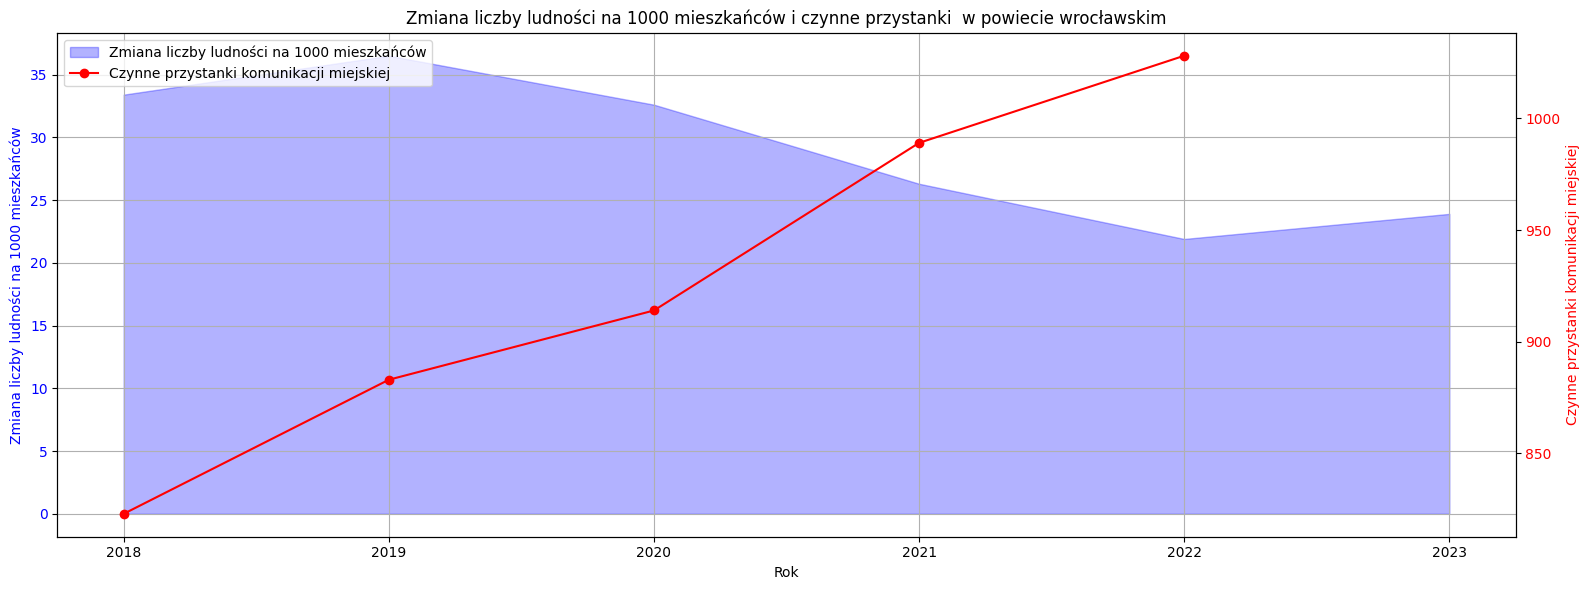

In [ ]:
plot_district_data(df, 'Powiat wrocławski', 'Czynne przystanki komunikacji miejskiej', 'Zmiana liczby ludności na 1000 mieszkańców i czynne przystanki  w powiecie wrocławskim',2018)

# Powiat krasnostawski

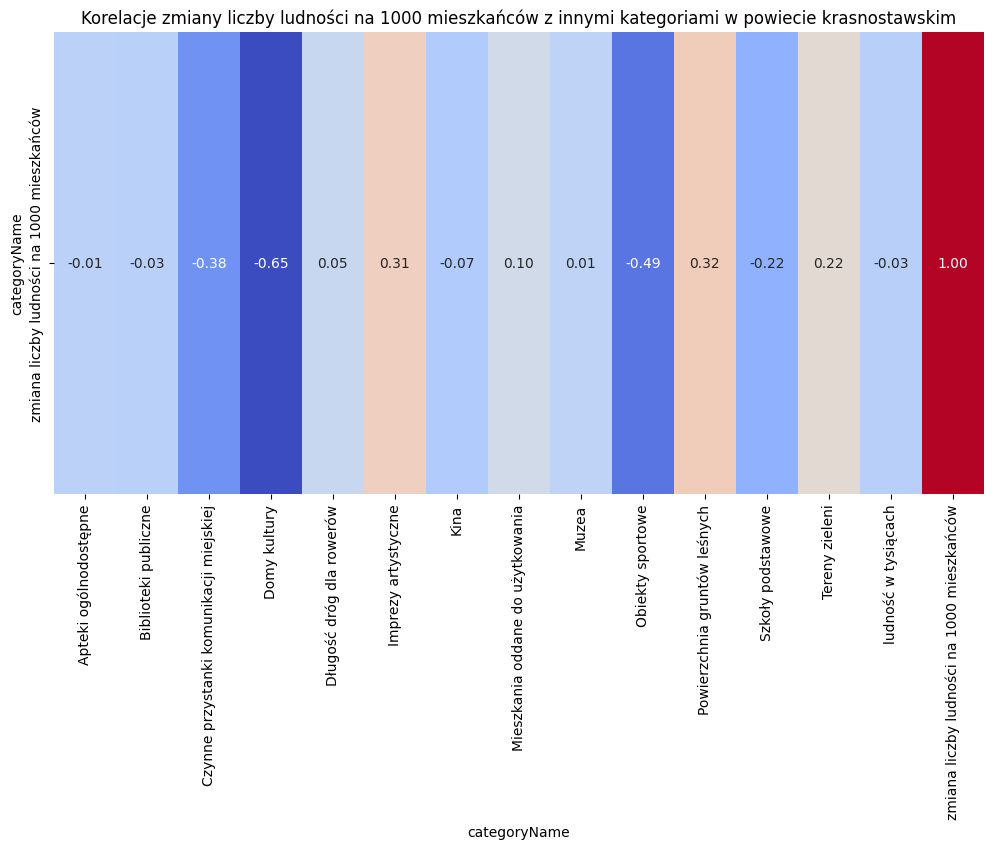

In [19]:
krasnostawski_df = df[df['powiatName'] == 'Powiat krasnostawski']
krasnostawski_df = krasnostawski_df[krasnostawski_df['categoryName'].isin(['Instytucje muzyczne', 'Teatry']) == False]
krasnostawski_df_pivot = krasnostawski_df.pivot_table(index='year', columns='categoryName', values='value')

selected_categories = ['zmiana liczby ludności na 1000 mieszkańców']
corr_matrix = krasnostawski_df_pivot.corr()
selected_corr_matrix = corr_matrix.loc[selected_categories]

plt.figure(figsize=(12, 6))
sns.heatmap(selected_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=False)
plt.title('Korelacje zmiany liczby ludności na 1000 mieszkańców z innymi kategoriami w powiecie krasnostawskim')
plt.show()

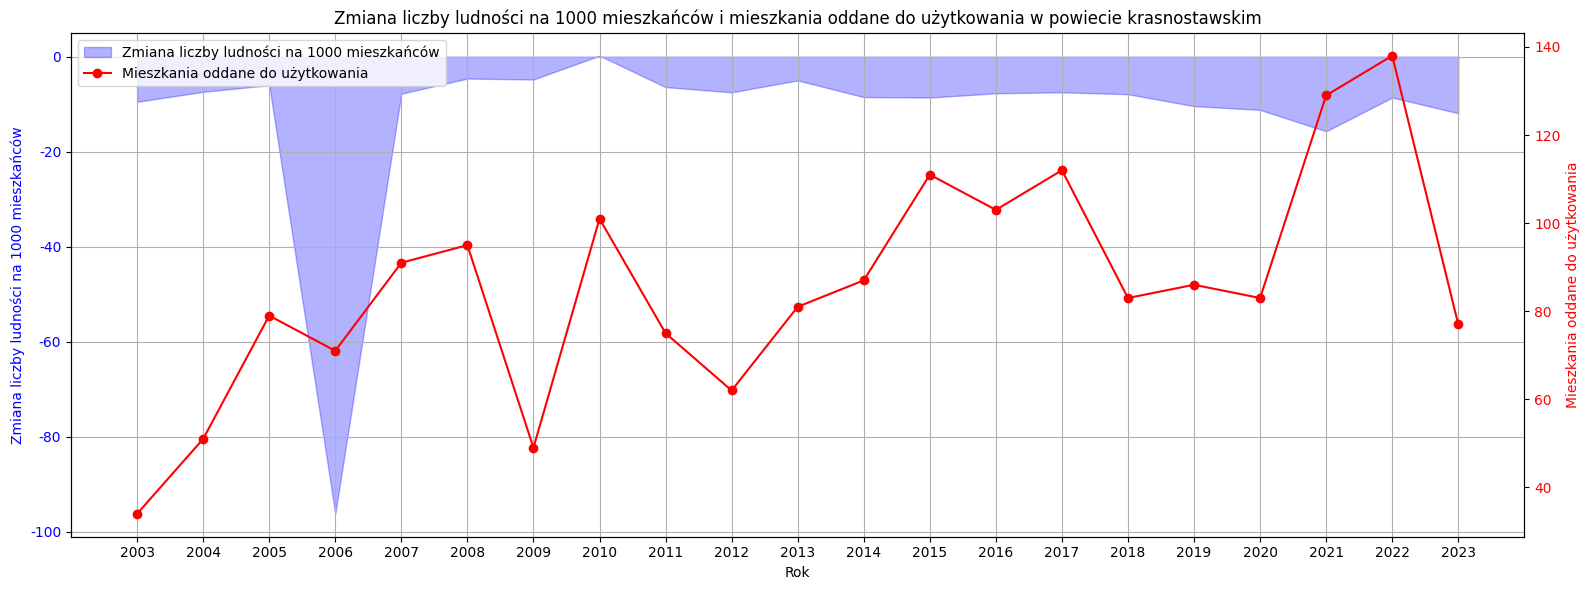

In [ ]:
plot_district_data(df, 'Powiat krasnostawski', 'Mieszkania oddane do użytkowania', 'Zmiana liczby ludności na 1000 mieszkańców i mieszkania oddane do użytkowania w powiecie krasnostawskim',2003)

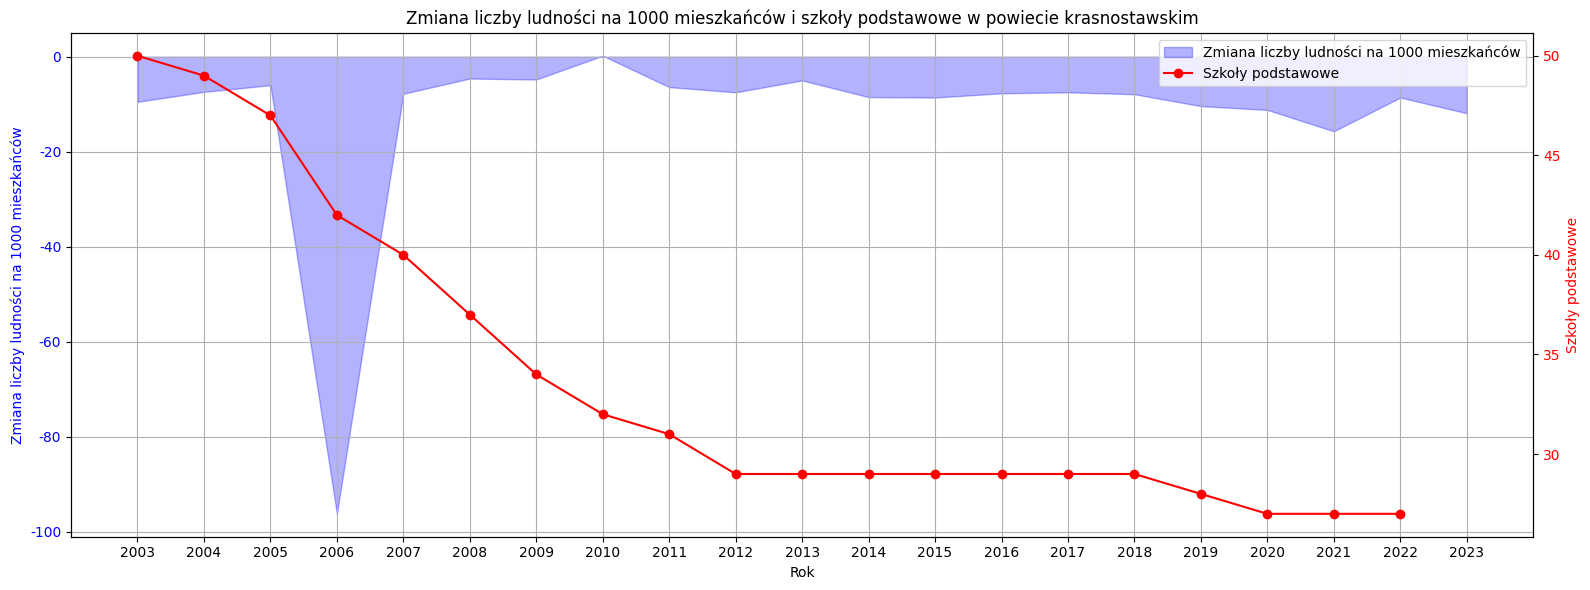

In [ ]:
plot_district_data(df, 'Powiat krasnostawski', 'Szkoły podstawowe', 'Zmiana liczby ludności na 1000 mieszkańców i szkoły podstawowe w powiecie krasnostawskim',2003)

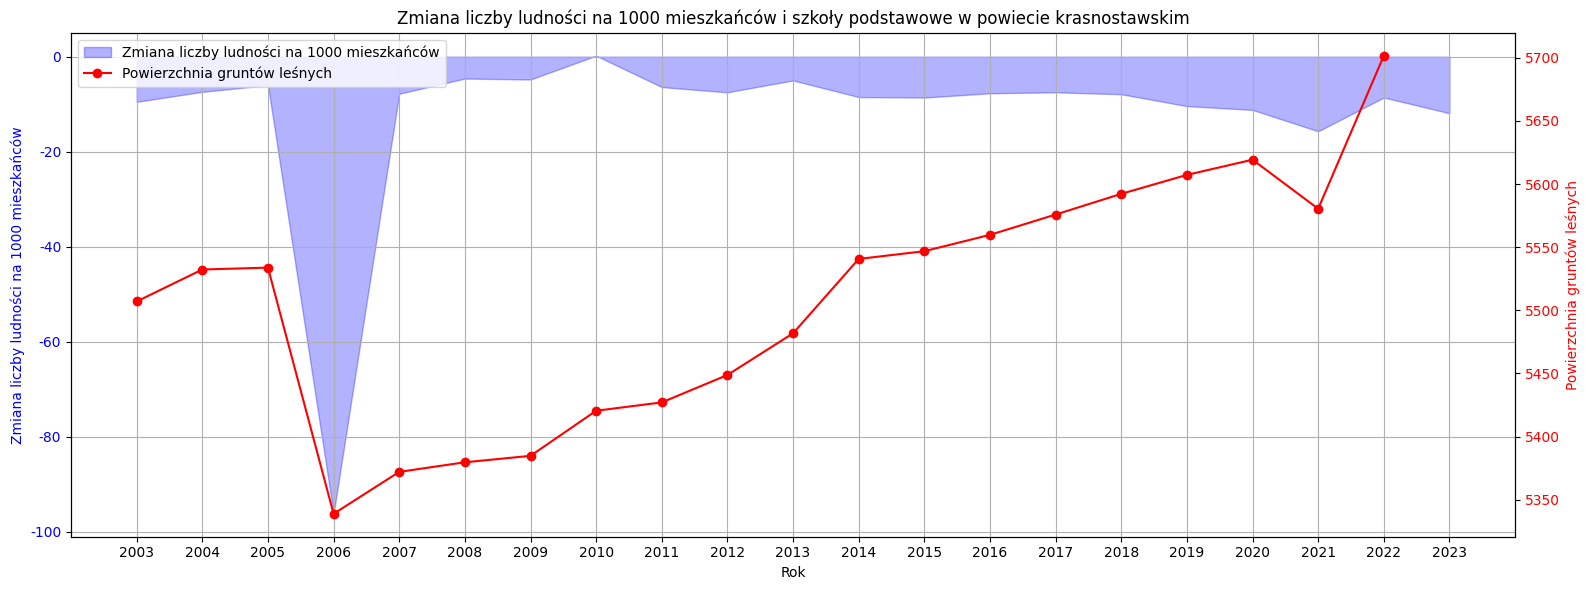

In [17]:
plot_district_data(df, 'Powiat krasnostawski', 'Powierzchnia gruntów leśnych', 'Zmiana liczby ludności na 1000 mieszkańców i szkoły podstawowe w powiecie krasnostawskim',2003)